In [1]:
import pandapower.networks as pn

net = pn.create_cigre_network_lv()

In [2]:
net.switch.loc[1, "closed"] = False
net.switch.loc[2, "closed"] = False

In [3]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source


In [4]:
import numpy as np
import pandas as pd

import pandapower as pp
import pandapower.control as control
import pandapower.networks as nw
import pandapower.timeseries as timeseries
from pandapower.timeseries.data_sources.frame_data import DFData

In [5]:
import pandas as pd
from pandapower.timeseries import DFData

# Load and preprocess the PV generation profile CSV file
df_pv = pd.read_csv("pv_generation_profile.csv")
df_pv['time'] = pd.to_datetime(df_pv['time'], format='%H:%M:%S').dt.time
df_pv['time_step'] = range(len(df_pv))  # Create a numerical index
df_pv.set_index('time_step', inplace=True)

df_pv['pvgen'] = df_pv['pvgen'] * 50/1000
# Ensure the DataFrame index is an integer starting from 0
ds_pv = DFData(df_pv)

In [6]:
# Load and preprocess the CSV file
df = pd.read_csv("load_profile_1111.csv")
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['time_step'] = range(len(df))  # Create a numerical index
df.set_index('time_step', inplace=True)

# Scale the 'mult' column to 5 kW
df['mult'] = df['mult'] * 15/1000

# Ensure that the DataFrame index is an integer starting from 0
ds = DFData(df)

In [7]:
# Set constant loads to 3 kW for all loads except R11 to R18
constant_loads = net.load.index.difference([1, 2, 3, 4, 5])  # Indices of loads R1, I2, C1, C12, C13, C14, C17, C18, C19, C20
net.load.loc[constant_loads, 'p_mw'] = 15/1000

In [8]:
import pandapower.control as control

# Add PV generators to the corresponding buses
pv_buses = [12, 16, 17, 18, 19]  # Buses of loads R11, R15, R16, R17, R18
pv_generators = []
for bus in pv_buses:
    pv_gen = pp.create_sgen(net, bus, p_mw=0, q_mvar=0, type='pv')
    pv_generators.append(pv_gen)

In [9]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,None,12,0.0,0.0,NaN,1.0,True,pv,True
1,None,16,0.0,0.0,NaN,1.0,True,pv,True
2,None,17,0.0,0.0,NaN,1.0,True,pv,True
3,None,18,0.0,0.0,NaN,1.0,True,pv,True
4,None,19,0.0,0.0,NaN,1.0,True,pv,True


In [10]:
# Initialize ConstControl controller to update values of the PV generators
const_pv = control.ConstControl(net, element='sgen', element_index=pv_generators,
                                variable='p_mw', data_source=ds_pv, profile_name=["pvgen"]*len(pv_generators))

In [11]:
# Initialize ConstControl controller to update values of the loads R11 to R18
profile_loads = net.load.index.intersection([0, 1, 2, 3, 4, 5])  # Indices of loads R11 to R18
const_load = control.ConstControl(net, element='load', element_index=profile_loads,
                                  variable='p_mw', data_source=ds, profile_name=["mult"]*len(profile_loads))

In [12]:
# Run a power flow for the initial condition to check if the network is properly configured
try:
    pp.runpp(net)
except pp.optimal_powerflow.OPFNotConverged:
    print("Initial power flow did not converge. Please check the network configuration.")

In [15]:
from pandapower.timeseries import OutputWriter, run_timeseries

# Create an OutputWriter to log the results
ow = OutputWriter(net, time_steps=range(len(df_pv)), output_path="./", output_file_type=".xlsx")
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_load', 'q_mvar')
ow.log_variable('res_sgen', 'p_mw')  # Log PV generation power
ow.log_variable('res_sgen', 'q_mvar')  # Log PV generation reactive power

# Run the time series simulation
run_timeseries(net, time_steps=range(len(df_pv)))

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:02<00:00, 47.17it/s]


In [16]:
# Load the results
vm_pu = pd.read_excel('res_bus/vm_pu.xlsx', index_col=0)
loading_percent = pd.read_excel('res_line/loading_percent.xlsx', index_col=0)
load_p_mw = pd.read_excel('res_load/p_mw.xlsx', index_col=0)
load_q_mvar = pd.read_excel('res_load/q_mvar.xlsx', index_col=0)
sgen_p_mw = pd.read_excel('res_sgen/p_mw.xlsx', index_col=0)
sgen_q_mvar = pd.read_excel('res_sgen/q_mvar.xlsx', index_col=0)

In [ ]:
import pandapower.plotting as plot
# Plot the grid
plot.simple_plot(net, show_plot=True)

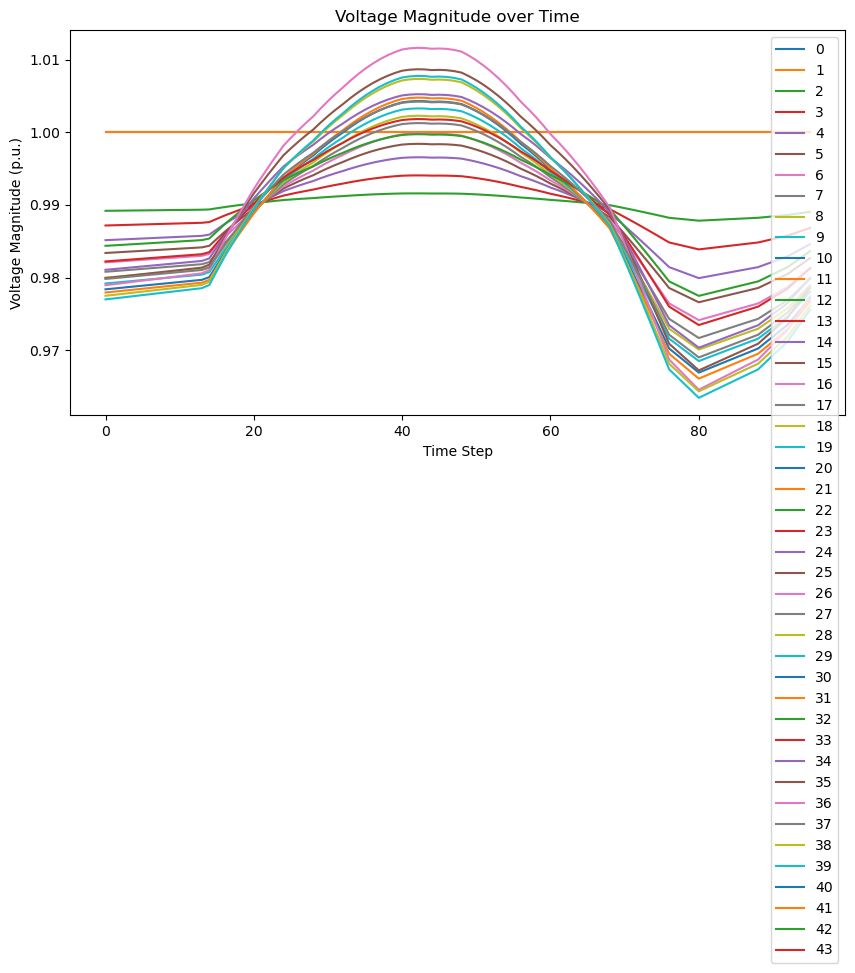

In [18]:
import matplotlib.pyplot as plt
# Generate the plots
plt.figure(figsize=(10, 5))
plt.plot(vm_pu, label=vm_pu.columns)
plt.xlabel('Time Step')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.title('Voltage Magnitude over Time')
plt.legend()
plt.show()


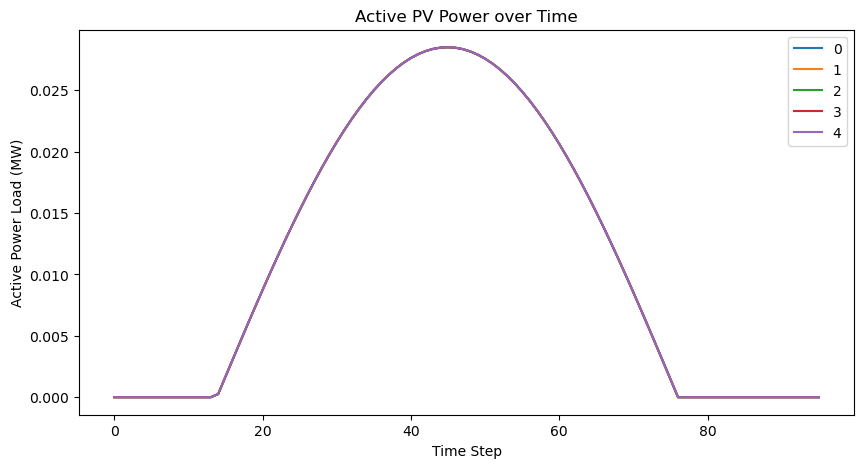

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(sgen_p_mw, label=sgen_p_mw.columns)
plt.xlabel('Time Step')
plt.ylabel('Active Power Load (MW)')
plt.title('Active PV Power over Time')
plt.legend()
plt.show()

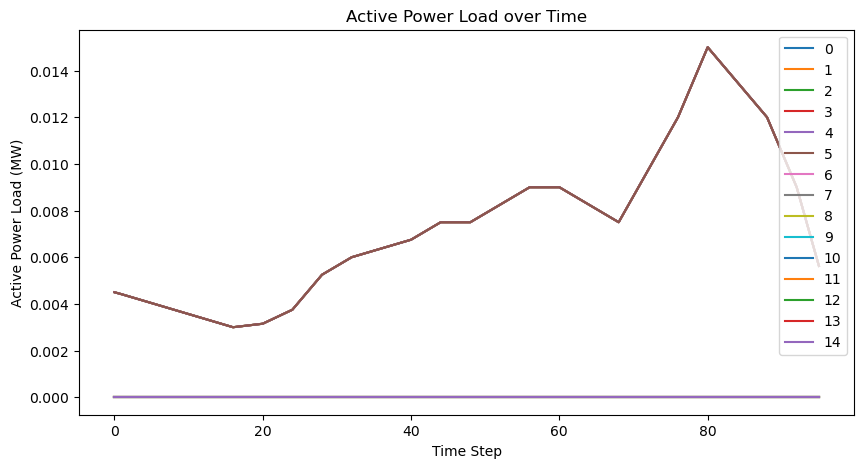

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(load_p_mw, label=load_p_mw.columns)
plt.xlabel('Time Step')
plt.ylabel('Active Power Load (MW)')
plt.title('Active Power Load over Time')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Print the first few rows of the PV generation profile
print(df_pv.head())

# Plot the PV generation profile
plt.plot(df_pv['pvgen'])
plt.title('PV Generation Profile')
plt.xlabel('Time Step')
plt.ylabel('MW')
plt.show()